# Summary



# Intro

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from biodata import *

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import functions as fn

In [4]:
from common import dat

In [5]:
%matplotlib inline

# Load data

## Read HDF

In [11]:
store = pd.HDFStore('machine_learning/ddc_data.h5', mode='r', complevel=9, complib='blosc')

In [17]:
df_train = store['ddc_data'][store['ddc_data']['source'] == 'train'].copy()

In [18]:
df_validate = store['ddc_data'][store['ddc_data']['source'] == 'ch1_validate'].copy()

In [19]:
store.close()

## Make chunks

In [25]:
chunk_size = 300
chunks = []
df_train = df_train.reindex(np.random.permutation(df_train.index))
for i in range(0, df_train.shape[0], chunk_size):
    train = pd.concat([df_train[0:i], df_train[i + chunk_size:]], ignore_index=True).copy()
    test = df_train[i:i + chunk_size].copy()
    print(len(train))
    print(len(test))

    # Make sure there is no same (d_1, d_2, c) in train and test
    test['unique_id'] = test[['d_1', 'd_2', 'c']].apply('.'.join, axis=1)
    train['unique_id'] = train[['d_1', 'd_2', 'c']].apply('.'.join, axis=1)
    test_unique_id = set(test['unique_id'])
    train = train[~train['unique_id'].isin(test_unique_id)]
    train_unique_id = set(train['unique_id'])
    print(len(train))
    print(len(test))
    assert not test_unique_id & train_unique_id, test_unique_id & train_unique_id

    # Make sure there are some (d_1, d_2) in train and test
    test_drug_pair = set(test[['d_1', 'd_2']].apply('.'.join, axis=1))
    train_drug_pair = set(train[['d_1', 'd_2']].apply('.'.join, axis=1))
    assert len(test_drug_pair & train_drug_pair) + 4 >= len(test_drug_pair), \
        (len(test_drug_pair & train_drug_pair), len(test_drug_pair))
    
    assert not train['synergy_score'].isnull().any()
    assert not test['synergy_score'].isnull().any()
    chunks.append((train, test))

1495
300
1477
300
1495
300
1482
300
1495
300
1487
300
1495
300
1487
300
1495
300
1481
300
1500
295
1487
295


## Pair features

In [35]:
GB_DDDD = [
    # Can't use synergy scores from these columns!!!
    # 'az_dream_2015.ALL_TRAINING_DATA_PAIR_GBDDDD',
]

GB_CC = [
    # Can't use synergy scores from these columns!!!
    # 'az_dream_2015.ALL_TRAINING_DATA_PAIR_GBCC',
    'cell_info_gbcc',
    'cnv_gbcc',
    'gex_gbcc',
    'methyl_gbcc',
    'mutations_gbcc',
    'achilles_rnai_gbcc',
]

In [37]:
GB_DDDD_DF = {}

engine = sa.create_engine(os.environ[BIODB_CONNECTION_STR] + "/az_dream_2015_features")

for key in GB_DDDD:
    df = pd.read_sql_query("select * from {}".format(key), engine)
    GB_DDDD_DF[key] = df
    
GB_CC_DF = {}
for key in GB_CC:
    df = pd.read_sql_query("select * from {}".format(key), engine)
    GB_CC_DF[key] = df


## Pair data (opt)

In [26]:
train_pair = fn.get_synergy_groups(train, pairwise=True)

   index       d  count_gbd  synergy_score_gbd_min  synergy_score_gbd_max  synergy_score_gbd_mean  synergy_score_gbd_std
0      1  ADAM17         69              -41.87792                80.9991                6.067302              18.924169
1     37  ADAM17         69              -41.87792                80.9991                5.545329              19.436573
2     44  ADAM17         69              -41.87792                80.9991                5.613013              19.426372
3     78  ADAM17         69              -41.87792                80.9991                5.519848              19.436138
4     81  ADAM17         69              -41.87792                80.9991                5.534359              19.436672
Skipping column 'd_1' because it appears to be a string...
1...
2...
3...
4...
5...
6...
7...
Skipping column 'c_x' because it appears to be a string...
Skipping column 'd_1_x' because it appears to be a string...
Skipping column 'd_2_x' because it appears to be a string...

In [29]:
feature_columns = get_feature_columns(train_pair)

c_x
d_1_x
d_2_x
source_x
d_1_stitch_x
d_2_stitch_x
unique_id_x
unique_id_stitch_x
c_stitch_x
tmp
index_y
c_y
d_1_y
d_2_y
synergy_score_y
qa_y
source_y
d_1_stitch_y
d_2_stitch_y
unique_id_y
unique_id_stitch_y
gi_neighbor_sharing_min_stitch_y
c_stitch_y
h_gbc_max_y
f_mutation_very_bad_density_gbc_min_y
f_mutation_very_bad_density_gbc_median_y
f_mutation_mild_density_gbc_min_y
f_mutation_mild_density_gbc_median_y
f_maybe_somatic_density_gbc_min_y
f_maybe_somatic_density_gbc_median_y
f_homozygous_density_gbc_min_y
f_homozygous_density_gbc_median_y
f_mutation_maybe_bad_density_gbc_min_y
f_snp_density_gbc_min_y
f_snp_density_gbc_median_y
h_gbd_max_mean_y
h_gbd_max_diff_y
einf_gbd_min_mean_y
einf_gbd_min_diff_y
index_diff
synergy_score_diff
qa_diff
gi_neighbor_sharing_min_stitch_diff
h_gbc_max_diff
f_mutation_very_bad_density_gbc_min_diff
f_mutation_very_bad_density_gbc_median_diff
f_mutation_mild_density_gbc_min_diff
f_mutation_mild_density_gbc_median_diff
f_maybe_somatic_density_gbc_min_dif

In [27]:
test_pair = fn.get_synergy_groups(train, test, pairwise=True)

`df_test` contains a 'synergy_score' column. This should not be done in production!
         d  synergy_score_gbd_min  synergy_score_gbd_max  synergy_score_gbd_mean  synergy_score_gbd_std  count_gbd
0   ADAM17              -41.87792               80.99910                5.537334              19.436688         70
1      AKT              -49.69178              100.00000               13.390077              26.439020        179
2    AKT_1              -38.83305              100.00000               16.644563              25.370433        124
3  AKT_SGK              -38.33838               63.79015               11.501519              18.803210         36
4      ALK              -36.25801               64.74079               16.527419              20.453413         36
Skipping column 'd_1' because it appears to be a string...
Skipping column 'd_1' because it appears to be a string...
1...
2...
3...
4...
5...
6...
7...
Skipping column 'c_x' because it appears to be a string...
Skipping colum

# SGDRegressor

- Check if keeping duplicates degrades performance...

In [26]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

In [27]:
# Have to do some gridsearching to find the best hyperparameters...
alpha = 10.0**-np.arange(1,7)
n_iter = np.ceil(10**6 / df_train.shape[0]),

In [31]:
!rm machine_learning/pair_xval_1.h5

rm: cannot remove ‘machine_learning/pair_xval_1.h5’: No such file or directory


In [ ]:
features_to_exclude = [
    'synergy_score', 'synergy_score_y', 'synergy_score_diff',
    'qa', 'qa_x', 'qa_y', 
    'cid_diff_diff', 'cid_diff_y', 'cid_mean_diff', 'cid_mean_y',
    'index', 'index_x', 'index_y', 'index_diff',
    'unique_id_x', 'unique_id_y',
]

def get_feature_columns(df):
    feature_columns = [
        c for c in df.columns 
        if (df[c].dtype in (int, float) and 
            c not in features_to_exclude and
            df[c].nunique() > 1)
            or print(c)
    ]
    return feature_columns


def add_identity_features(df):
    """Same cell, same drug, same drug pair, etc...
    """
    df['same_cell'] = (
        (df['c_x'] == df['c_y'])
    ).astype(int)

    df['same_drug_pair'] = (
        (df['d_1_x'] == df['d_1_y']) & 
        (df['d_2_x'] == df['d_2_y'])
    ).astype(int)

    xy_df['same_drug'] = (
        ~(df['same_drug_pair']) & 
        ((df['d_1_x'] == df['d_1_y']) | (df['d_1_x'] == df['d_2_y']) | 
         (df['d_2_x'] == df['d_1_y']) | (df['d_2_x'] == df['d_2_y']))
    ).astype(int)


def add_dddd_features(df):
    """Ass drug pair - drug pair feautres to a pair DataFrame df
    """
    pass


def add_cc_features(df):
    """Ass cell line - cell line feautres to a pair DataFrame df
    """
    pass


def add_dc_features(df):
    """Ass cell line - cell line feautres to a pair DataFrame df
    """
    pass

In [40]:
imputer = Imputer()
scaler = StandardScaler()

xval_results = []
xval_results_xval = []

cache = pd.HDFStore('machine_learning/pair_xval_1.h5', mode='w', complevel=9, complib='blosc')

for chunk_i, (train, test_wsyn) in enumerate(chunks):
    print("\nWorking on chunk {}...".format(chunk_i))
    print("train: {}".format(train.shape))
    print("test: {}".format(test.shape))
    sys.stdout.flush()

    # ========== TRAIN ==========
    train_pair_name = 'train_pair_{}'.format(chunk_i)
    if train_pair_name not in cache:
        print("Calculating 'train_pair'..."); sys.stdout.flush()
        train_pair = fn.get_synergy_groups(train, pairwise=True)
        
        for name, df in GB_DDDD_DF.items():
            print("Merging '{}'...".format(name))
            train_pair = train_pair.merge(df, on=['d_1_x', 'd_2_x', 'd_1_y', 'd_2_y'], how='left')
        for name, df in GB_CC_DF.items():
            print("Merging '{}'...".format(name))
            train_pair = train_pair.merge(df, on=['c_x', 'c_y'], how='left')

        train_pair['unique_id_x'] = (train_pair['d_1_x'] + '.' + train_pair['d_2_x'] + '.' + train_pair['c_x'])
        train_pair['unique_id_y'] = (train_pair['d_1_y'] + '.' + train_pair['d_2_y'] + '.' + train_pair['c_y'])
        train_pair = train_pair[train_pair['unique_id_x'] != train_pair['unique_id_y']]
        
        feature_columns = get_feature_columns(train_pair)
        
        # Save for future
        cache[train_pair_name] = train_pair
        cache['feature_columns'] = feature_columns

    else:
        print("Loading train data from cache..."); sys.stdout.flush()
        train_pair = cache[train_pair_name]
        feature_columns = cache['feature_columns']

        
    # ========== TEST ==========
    test_pair_name = 'test_pair_{}'.format(chunk_i)
    if test_pair_name not in cache:
        print("Calculating 'test_pair'..."); sys.stdout.flush()
        test = test_wsyn.drop('synergy_score', axis=1)
        test_pair = fn.get_synergy_groups(train, test, pairwise=True)
        
        for name, df in GB_DDDD_DF.items():
            print("Merging '{}'...".format(name))
            test_pair = test_pair.merge(df, on=['d_1_x', 'd_2_x', 'd_1_y', 'd_2_y'], how='left')
        for name, df in GB_CC_DF.items():
            print("Merging '{}'...".format(name))
            test_pair = test_pair.merge(df, on=['c_x', 'c_y'], how='left')
            
        test_pair['unique_id_x'] = test_pair[['d_1_x', 'd_2_x', 'c_x']].apply('.'.join, axis=1)
        test_pair['unique_id_y'] = test_pair[['d_1_y', 'd_2_y', 'c_y']].apply('.'.join, axis=1)

        cache[test_pair_name] = test_pair
    else:
        print("Loading test data from cache..."); sys.stdout.flush()
        test_pair = cache[test_pair_name]

        
    # ========== Normalize input ==========
    print("scaling..."); sys.stdout.flush()

    X = train_pair[feature_columns].fillna(0).values
    X_test = test_pair[feature_columns].values

    scaler.fit(np.vstack([X, X_test]))

    X = scaler.transform(X)
    X_test = scaler.transform(X_test)

    Y = train_pair['synergy_score_y'].values

    break


Working on chunk 0...
train: (1477, 834)
test: (295, 834)
Calculating 'train_pair'...
   index       d  count_gbd  synergy_score_gbd_mean
0     16  ADAM17         68                4.214812
1     34  ADAM17         68                4.025141
2     51  ADAM17         68                4.152422
3    106  ADAM17         68                4.147405
4    149  ADAM17         68                4.146106
Skipping column 'd_1' because it appears to be a string...
1...
2...
3...
4...
5...
6...
7...
Skipping column 'c_x' because it appears to be a string...
Skipping column 'd_1_x' because it appears to be a string...
Skipping column 'd_2_x' because it appears to be a string...
Skipping column 'source_x' because it appears to be a string...
Skipping column 'd_1_stitch_x' because it appears to be a string...
Skipping column 'd_2_stitch_x' because it appears to be a string...
Skipping column 'unique_id_x' because it appears to be a string...
Skipping column 'unique_id_stitch_x' because it appears to 

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['c_x', 'd_1_x', 'd_2_x', 'source_x', 'd_1_stitch_x', 'd_2_stitch_x', 'unique_id_x', 'unique_id_stitch_x', 'c_stitch_x', 'c_y', 'd_1_y', 'd_2_y', 'source_y', 'd_1_stitch_y', 'd_2_stitch_y', 'unique_id_y', 'unique_id_stitch_y', 'c_stitch_y', 'achilles_rnai_sqeuclidean', 'achilles_rnai_sscgs_chebyshev', 'achilles_rnai_gs_seuclidean', 'achilles_rnai_gs_sscgs_seuclidean']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
cache.close()

In [73]:
    # ========== PROCESS ==========
    # Save predictions
    test_pair_wsyn = (
        test_pair.drop('synergy_score_y', axis=1)
        .merge(
            test_wsyn[['d_1', 'd_2', 'c', 'synergy_score']]
            .drop_duplicates(subset=['d_1', 'd_2', 'c'])  # TODO: merge on index instead of this hack...
            .rename(columns={'d_1': 'd_1_y', 'd_2': 'd_2_y', 'c': 'c_y', 'synergy_score': 'synergy_score_y'}),
            on=['d_1_y', 'd_2_y', 'c_y'],
            how='left')
    )

In [144]:
    assert X_test.shape[0] == train.shape[0] * test.shape[0]
    
    clf = SGDRegressor(n_iter=50)
    
    print("fitting..."); sys.stdout.flush()
    #sample_weight = np.ones(Y.shape)
    #sample_weight[Y < 0.2] = 0.5  # TODO: tune this parameter
    #clf.fit(X, Y, sample_weight=sample_weight)
    clf.fit(X, Y)
    
    # Predict
    Y_test = clf.predict(X_test)
    test_pair['synergy_score_y_pred'] = Y_test

fitting...


KeyboardInterrupt: 

## Tensorflow

In [11]:
import tensorflow as tf

In [10]:
# Linear regression

batch_size = 128
layer_1_size = 32
num_labels = 1

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, len(feature_columns)))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    tf_valid_dataset = tf.placeholder(tf.float32, shape=(None, len(feature_columns)))
    # tf_test_dataset = tf.placeholder(tf.float32, shape=(test_df.shape[0], len(feature_columns)))

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([len(feature_columns), num_labels], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([num_labels]))
    #layer2_weights = tf.Variable(tf.truncated_normal([layer_1_size, num_labels], stddev=0.1))
    #layer2_biases = tf.Variable(tf.zeros([num_labels]))
    #layer3_weights = tf.Variable(tf.truncated_normal([256, num_labels]))
    #layer3_biases = tf.Variable(tf.zeros([num_labels]))
  
    def model(data, train=False):
        hidden = tf.matmul(data, layer1_weights) + layer1_biases
        #hidden = tf.nn.relu(hidden)
        #if train:
        #    hidden = tf.nn.dropout(hidden, 0.5)
        #hidden = tf.matmul(hidden, layer2_weights) + layer2_biases
        #hidden = tf.matmul(hidden, layer3_weights) + layer3_biases
        return hidden

    logits = model(tf_train_dataset, train=True)
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    #weights = (
    #    0.8 * tf.to_float(tf_train_labels > 20) + 
    #    0.2 * tf.to_float(tf_train_labels <= 20)
    #)
    #loss = tf.reduce_mean(tf.square(logits - tf_train_labels) * weights)
    loss = tf.reduce_mean(tf.square(logits - tf_train_labels))
    
    # Add regularization
    regularizers = (
        tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) # +
        #tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases)
        #tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases)
    )
    loss += 1e-2 * regularizers

    # Optimizer.
    step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(0.5, step, 1, 0.9999)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = logits
    valid_prediction = model(tf_valid_dataset)
    # test_prediction = tf.nn.softmax(model(tf_test_dataset))

NameError: name 'tf' is not defined

In [84]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

num_steps = 501
scale_factor = 1

output_dfs = []

train_df, test_df = chunks[0]

valid_dataset, valid_labels = shuffle(X_test, test_pair_wsyn[['synergy_score_y']].values)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Shuffle our data
        indexes = np.random.permutation(X.shape[0])
        # Collect predictions from every minibatch
        batch_loss_all = []
        predictions_all = []
        batch_labels_all = []
        for offset in range(0, X.shape[0], batch_size):
            # Generate a minibatch.
            batch_data = X[indexes[offset:(offset + batch_size)], :]
            batch_labels = Y.reshape((-1, 1))[indexes[offset:(offset + batch_size)], :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {
                tf_train_dataset: batch_data, 
                tf_train_labels: batch_labels,
            }
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            # ...
            batch_loss_all.append(l)
            predictions_all.append(predictions)
            batch_labels_all.append(batch_labels)
        # ...
        batch_loss = np.vstack(batch_loss_all)
        predictions = np.vstack(predictions_all)
        batch_labels = np.vstack(batch_labels_all)
        # Once every while, check how we are doing...
        if True:  # (step % 10 == 0):
            print("Minibatch loss at step %d: %f" % (step, np.mean(batch_loss)))
            if False:
                print("Minibatch accuracy: %.2f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.2f%%" % accuracy(v_prediction, valid_labels))
                fpr, tpr, thresholds = roc_curve(valid_labels[:, 0], v_prediction[:, 0])
                bac = (tpr + (1 - fpr)) / 2
                print('bac: {:.2f}\n'.format(max(bac)))
            else:
                # Minibatch
                print("Minibatch correlation: {}".format(sp.stats.pearsonr(predictions, batch_labels)[0]))
                # Validation
                y_pred_all = []
                for step_train in range(0, valid_dataset.shape[0], batch_size):
                    y_pred_chunk = (
                        valid_prediction.eval(
                            feed_dict={tf_valid_dataset: valid_dataset[step_train:step_train + batch_size]})
                    )
                    y_pred_all.append(y_pred_chunk)
                y_pred = np.vstack(y_pred_all)
                print("Validation correlation: {}".format(sp.stats.pearsonr(y_pred, valid_labels)[0]))
            print()
            sys.stdout.flush()

    #saver.save(session, 'machine_learning/tensorflow_ch1', global_step=step)
    #print("Test accuracy: %.2f%%" % accuracy(test_prediction.eval(), test_labels))

output_df = test_df[['d_1', 'd_2', 'c', 'synergy_score']].copy()
output_df['synergy_score_pred'] = y_pred
output_dfs.append(output_df)
# break

Initialized
Minibatch loss at step 0: 262.259064
Minibatch correlation: [ 0.80480385]
Validation correlation: [ 0.39399117]

Minibatch loss at step 1: 210.352341
Minibatch correlation: [ 0.86869101]
Validation correlation: [ 0.38408444]

Minibatch loss at step 2: 200.807114
Minibatch correlation: [ 0.88444104]
Validation correlation: [ 0.39015026]

Minibatch loss at step 3: 196.895584
Minibatch correlation: [ 0.89239945]
Validation correlation: [ 0.3803095]



KeyboardInterrupt: 

In [190]:
X.shape

(2200706, 1824)

In [161]:
test_pair_wsyn[['synergy_score_y']].head()

,synergy_score_y
0,29.359150
1,-31.030500
2,100.000000
3,9.376265
4,1.119112


In [72]:
    xval_results.append(
        test_pair_wsyn
        # TODO: Make sure don't get much better performance if predicting differences
        [['d_1_x', 'd_2_x', 'c_x', 'd_1_y', 'd_2_y', 'c_y', 'synergy_score_y', 'synergy_score_y_pred']]
    )

    # Some concluding remarks
    print("train: {}".format(train.shape))
    print("train_pair: {}".format(train_pair.shape))
    print("test: {}".format(test.shape))
    print("test_pair: {}".format(test_pair.shape))
    print("test_pair_wsyn: {}".format(test_pair_wsyn.shape))
    print(set(feature_columns) - set(test_pair.columns))
    global_corr = (
        sp.stats.pearsonr(
            test_pair_wsyn['synergy_score_y'],
            test_pair_wsyn['synergy_score_y_pred']
        ))
    print("global_corr: {}".format(global_corr))

    sys.stdout.flush()

# Overall globel corr
xval_results_final = pd.concat(xval_results, ignore_index=False)
global_corr = (
    sp.stats.pearsonr(
        xval_results_final['synergy_score_y'],
        xval_results_final['synergy_score_y_pred']
    ))
print("final global_corr: {}".format(global_corr))

# Overall GBDD corr
xval_results_final2 = (
    xval_results_final
    .groupby(['d_1_y', 'd_2_y', 'c_y'])
    [['synergy_score_y', 'synergy_score_y_pred']]
    .agg('mean')
    .reset_index()
    .rename(
        columns={
            'd_1_y': 'd_1',
            'd_2_y': 'd_2',
            'c_y': 'c',
            'synergy_score_y': 'synergy_score',
            'synergy_score_y_pred': 'synergy_score_pred'
        })
)
local_corr = fn.get_score_ch1(xval_results_final2)
print("final local_corr: {}".format(local_corr))

#xval_results_xval.append([clf_opts, xval_results_final])

train: (1485, 834)
train_pair: (2203682, 1887)
test: (300, 834)
test_pair: (445500, 1886)
test_pair_wsyn: (445500, 1886)
set()
global_corr: (0.0020474319831092548, 0.17175944356997189)
final global_corr: (0.0031324921103409089, 0.013232718561041945)
Skipping key '('ADAM17', 'AKT')' because it has only 1 value...
Skipping key '('AKT', 'AKT_1')' because it has only 1 value...
Skipping key '('AKT', 'PIK3C_2')' because it has only 1 value...
Skipping key '('AKT_1', 'BCL2L1')' because it has only 1 value...
Skipping key '('AKT_1', 'Chloroquine')' because it has only 1 value...
Skipping key '('AKT_1', 'ESR1')' because it has only 1 value...
Skipping key '('AKT_1', 'ESR1_1')' because it has only 1 value...
Skipping key '('AKT_1', 'PIK3C_2')' because it has only 1 value...
Skipping key '('AKT_SGK', 'BCL2_BCL2L1')' because it has only 1 value...
Skipping key '('ALK', 'EGFR_2')' because it has only 1 value...
Skipping key '('ALK', 'PIK3C')' because it has only 1 value...
Skipping key '('ALK_2', 

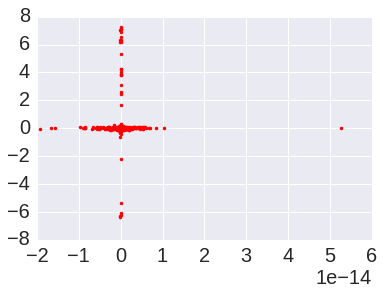

In [94]:
plt.plot(X.mean(axis=0), X_test.mean(axis=0), 'r.')
#plt.xlim(-0.05e-1, 0.05e-1)
#plt.ylim(-0.05e-1, 0.05e-1)

(-50000000000.0, 50000000000.0)

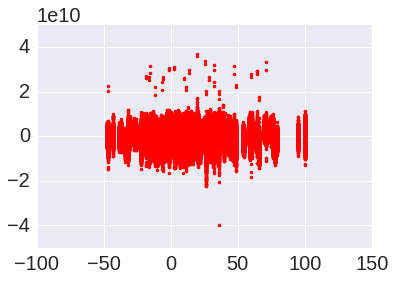

In [87]:
plt.plot(
    test_pair_wsyn['synergy_score_y'], 
    test_pair_wsyn['synergy_score_y_pred'], 
    'r.')
plt.xlim(-100, 150)
plt.ylim(-0.05e12, 0.05e12)

In [65]:
1485 * 300

445500

In [68]:
1485 * 1484

2203740

In [ ]:
len(set(train_pair[feature_columns].columns))

In [ ]:
len(set(test_pair[feature_columns].columns))

In [ ]:
sp.stats.pearsonr(
    xval_results_final['synergy_score_y'],
    xval_results_final['synergy_score_y_pred']
)

In [ ]:
xval_results_final2.head()

# Compare `test` and `train` feautes

In [70]:
X_mean = X.mean(axis=0)

In [71]:
X_test_mean = X_test.mean(axis=0)

(-0.25, 0.25)

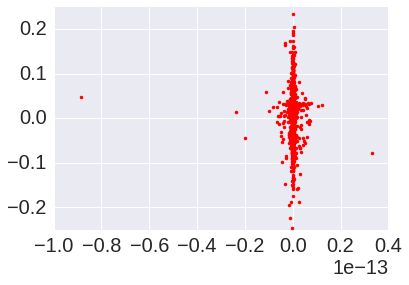

In [72]:
plt.plot(X_mean, X_test_mean, 'r.')
plt.ylim(-0.25, 0.25)

In [66]:
bad = [
    (i, c, '{:.2f}'.format(m2 - m1)) 
    for (i, (c, m1, m2)) in enumerate(zip(feature_columns, X_mean, X_test_mean))
    if abs(m1 - m2) > 0.51 and c[-3:] not in  ['_11', '_12', '_21', '_22']
]
print(bad)

[(714, 'count_gbdc_diff_y', '-0.53'), (815, 'count_gbcc_x', '6.24'), (817, 'count_gbdddd_x', '3.98'), (819, 'synergy_score_gbcc_mean', '3.29'), (820, 'synergy_score_gbdddd_mean', '1.75'), (822, 'synergy_score_gbdcdc_mean', '2.62')]


In [54]:
feature_columns_original = feature_columns.copy()

In [69]:
feature_columns.remove('count_gbdc_diff_y')
feature_columns.remove('count_gbcc_x')
feature_columns.remove('count_gbdddd_x')
feature_columns.remove('synergy_score_gbcc_mean')
feature_columns.remove('synergy_score_gbdddd_mean')
feature_columns.remove('synergy_score_gbdcdc_mean')

In [68]:
n = [820, 819, 817, 815, 714]
X = np.delete(X, n, axis=1)
X_test = np.delete(X_test, n, axis=1)

In [52]:
len(feature_columns)

1766

In [53]:
feature_columns

['synergy_score_x',
 'max_conc_max_y',
 'max_conc_min_y',
 'max_conc_diff_y',
 'max_conc_same_y',
 'ic50_mean_y',
 'ic50_diff_y',
 'h_mean_y',
 'h_diff_y',
 'einf_mean_y',
 'einf_diff_y',
 'count_gbdd_y',
 'max_conc_gbdd_mean_max_y',
 'max_conc_gbdd_mean_min_y',
 'max_conc_gbdd_mean_diff_y',
 'max_conc_gbdd_mean_same_y',
 'max_conc_gbdd_std_max_y',
 'max_conc_gbdd_std_min_y',
 'max_conc_gbdd_std_diff_y',
 'max_conc_gbdd_std_same_y',
 'max_conc_gbdd_max_max_y',
 'max_conc_gbdd_max_min_y',
 'max_conc_gbdd_max_diff_y',
 'max_conc_gbdd_max_same_y',
 'max_conc_gbdd_min_max_y',
 'max_conc_gbdd_min_min_y',
 'max_conc_gbdd_min_diff_y',
 'max_conc_gbdd_min_same_y',
 'ic50_gbdd_mean_mean_y',
 'ic50_gbdd_mean_diff_y',
 'ic50_gbdd_std_mean_y',
 'ic50_gbdd_std_diff_y',
 'ic50_gbdd_max_mean_y',
 'ic50_gbdd_max_diff_y',
 'ic50_gbdd_min_mean_y',
 'ic50_gbdd_min_diff_y',
 'h_gbdd_mean_mean_y',
 'h_gbdd_mean_diff_y',
 'h_gbdd_std_mean_y',
 'h_gbdd_std_diff_y',
 'h_gbdd_max_mean_y',
 'h_gbdd_max_diff_y',

## Correct features

In [ ]:
# Main features

In [ ]:
assert ALL_TRAINING_DATA_PAIR['same_cell'].any()
assert ALL_TRAINING_DATA_PAIR['same_drug_pair'].any()
assert ALL_TRAINING_DATA_PAIR['same_drug'].any()

assert not (ALL_TRAINING_DATA_PAIR['same_drug_pair'] & ALL_TRAINING_DATA_PAIR['same_drug']).any()